In [1]:
from google.colab import files
uploaded = files.upload()  # Select your cpu_usage_*.json files


Saving cpu_usage_2.json to cpu_usage_2.json


In [10]:
import json
import numpy as np
import glob
from collections import defaultdict

# Get all JSON files
files = glob.glob("cpu_usage_*.json")

timestamps = []
cpu_data = defaultdict(list)  # Stores CPU usage per core

for file in files:
    with open(file) as f:
        data = json.load(f)

        for result in data['data']['result']:
            cpu_id = result["metric"]["cpu"]  # Get CPU core ID

            for point in result['values']:
                timestamp = int(point[0])
                usage = float(point[1])

                if timestamp not in timestamps:
                    timestamps.append(timestamp)

                cpu_data[cpu_id].append(usage)

# Sort timestamps and convert to numpy
timestamps = np.array(sorted(timestamps)).reshape(-1, 1)

# Convert CPU usage data into a 2D array (rows = timestamps, cols = CPU cores)
cpu_matrix = np.array([cpu_data[cpu] for cpu in sorted(cpu_data.keys())]).T  # Transpose to match (samples, features)

print("Timestamps shape:", timestamps.shape)
print("CPU Usage Matrix shape:", cpu_matrix.shape)


Timestamps shape: (1441, 1)
CPU Usage Matrix shape: (1441, 4)


In [11]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Example of loading and preprocessing data (this part should be based on your actual data)
# Assuming 'timestamps' and 'cpu_matrix' are already loaded from your dataset
# 'timestamps' are the timestamps and 'cpu_matrix' contains the CPU usage data for all cores

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(timestamps, cpu_matrix, test_size=0.2, random_state=42)

# Train a multi-output regression model
model = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Predict future CPU usage (example: 10 minutes ahead)
future_timestamp = np.array([[X_test[0][0] + 600]])  # Predict 10 minutes ahead
predicted_usage = model.predict(future_timestamp)

print(f"Predicted CPU usage at {future_timestamp[0][0]}:")
for i, usage in enumerate(predicted_usage[0]):
    print(f"  CPU {i}: {usage:.4f}")

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Convert predictions and actual values into a DataFrame
df_results = pd.DataFrame(X_test, columns=["Timestamp"])
for i in range(y_test.shape[1]):
    df_results[f"Actual_CPU_{i}"] = y_test[:, i]
    df_results[f"Predicted_CPU_{i}"] = y_pred[:, i]

# Save to a CSV file for analysis
df_results.to_csv("cpu_prediction_results.csv", index=False)
print("Results saved to cpu_prediction_results.csv")


Predicted CPU usage at 1741616565:
  CPU 0: 0.0124
  CPU 1: 0.0131
  CPU 2: 0.0075
  CPU 3: 0.0036
Mean Squared Error: 6.651510619365899e-06
Results saved to cpu_prediction_results.csv


In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2}")


R² Score: 0.34921816654500326


In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation MSE scores: {scores}")
print(f"Average MSE: {scores.mean()}")


Cross-validation MSE scores: [-5.17710201e-06 -6.24224900e-06 -6.59292142e-06 -6.64951489e-06
 -6.38011292e-06]
Average MSE: -6.20838004906522e-06


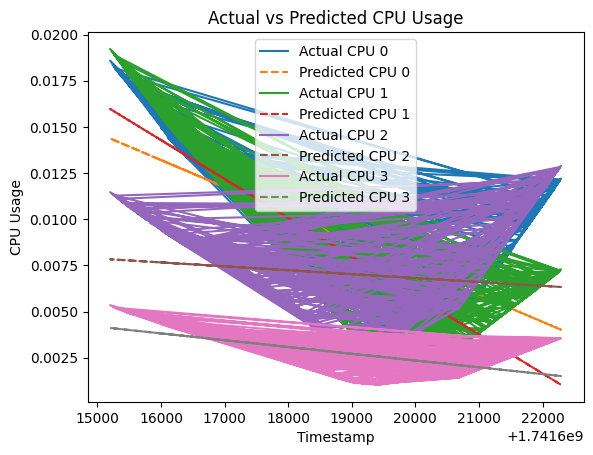

In [15]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
for i in range(y_test.shape[1]):
    plt.plot(df_results['Timestamp'], df_results[f"Actual_CPU_{i}"], label=f"Actual CPU {i}")
    plt.plot(df_results['Timestamp'], df_results[f"Predicted_CPU_{i}"], label=f"Predicted CPU {i}", linestyle='--')

plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage")
plt.title("Actual vs Predicted CPU Usage")
plt.show()
